## Training a GAN on Chair Pictures

https://www.tensorflow.org/tutorials/generative/dcgan

In [216]:
import tensorflow as tf

In [217]:
tf.__version__

'2.6.0'

In [218]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from pathlib import Path


## Load data

In [219]:
data_dir = Path("data")
len(list(data_dir.glob('*/*.jpg')))
img_dim = 80
noise_dim = 1000
lr_gen = 0.0002
lr_dis = 0.0002

In [220]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
#  source https://www.kaggle.com/arminajdehnia/antic-chairs
train_dataset= tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_dim, img_dim),
    batch_size=128,
    color_mode="grayscale",
    labels=None)

Found 1403 files belonging to 1 classes.
Using 1123 files for training.


In [221]:
train_dataset 

<BatchDataset shapes: (None, 80, 80, 1), types: tf.float32>

In [222]:
# train_images = train_images.reshape(train_images.shape[0], img_dim, img_dim, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [223]:
BUFFER_SIZE = 60000
BATCH_SIZE = 128

In [224]:
# Batch and shuffle the data
# train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [225]:
train_dataset

<BatchDataset shapes: (None, 80, 80, 1), types: tf.float32>

## Create Models

### The Generator

In [226]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(10*10*256, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((10, 10, 256)))
    assert model.output_shape == (None, 10, 10, 256)

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 10, 10, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 10, 10, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 20, 20, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 20, 20, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 40, 40, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 40, 40, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 40, 40, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 40, 40, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 40, 40, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (2, 2), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, img_dim, img_dim, 1)

    return model

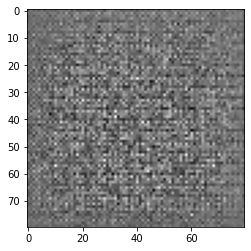

In [227]:
generator = make_generator_model()

noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [228]:
generated_image

<tf.Tensor: shape=(1, 80, 80, 1), dtype=float32, numpy=
array([[[[-6.17736485e-04],
         [ 3.53509357e-04],
         [-6.67540531e-04],
         ...,
         [-1.48527033e-04],
         [-1.63313598e-04],
         [-3.54803255e-04]],

        [[ 2.92275363e-04],
         [-2.32512175e-04],
         [ 5.63899404e-04],
         ...,
         [ 3.41239298e-04],
         [ 9.54550400e-04],
         [ 1.21459510e-04]],

        [[-8.08654004e-04],
         [ 2.25314405e-04],
         [-9.04662535e-04],
         ...,
         [ 6.00811269e-04],
         [ 8.09907040e-04],
         [-4.60091251e-04]],

        ...,

        [[ 5.06799726e-04],
         [-1.50643638e-04],
         [ 6.55400043e-04],
         ...,
         [ 1.10316018e-04],
         [-1.27510604e-04],
         [-5.27003838e-04]],

        [[ 1.24498605e-04],
         [-2.10090919e-04],
         [ 1.03045815e-04],
         ...,
         [-1.58275390e-04],
         [ 1.68533530e-04],
         [-5.97572252e-05]],

        [[

### The Discriminator

In [229]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[img_dim, img_dim, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(64, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(32, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [230]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-1.1636259e-06]], shape=(1, 1), dtype=float32)


## Loss Function and Optimizer

In [231]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [232]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss

    return total_loss

In [233]:
def generator_loss(fake_output):
    loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    
    return loss

In [234]:
generator_optimizer = tf.keras.optimizers.Adam(lr = lr_gen, beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr = lr_dis, beta_1 = 0.5)

/opt/homebrew/Caskroom/miniforge/base/envs/pytorchEnv/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


### Safe Breakpoints

In [235]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Training Loop

In [236]:
EPOCHS = 100
noise_dim = 1000
num_examples_to_generate = 5

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [237]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
    
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
      
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    tf.print(gen_loss)
    tf.print(disc_loss)


In [238]:
def train(dataset, epochs):
    for epoch in range(epochs):
      start = time.time()
      count = 1
      for image_batch in dataset:
        train_step(image_batch)
      # Produce images for the GIF as you go
      display.clear_output(wait=True)
      generate_and_save_images(generator,
                              epoch + 1,
                              seed)

      # Save the model every 15 epochs
      if (epoch + 1) % 20 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

      print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)

In [239]:
def generate_and_save_images(model, epoch, test_input):
      # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(10, 5))

  for i in range(predictions.shape[0]):
      plt.subplot(5, 10, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('output/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Training the Model

In [240]:
# set up loss monitoring
disc_loss_vec = []
gen_loss_vec = []


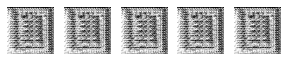

In [241]:
train(train_dataset, EPOCHS)

In [242]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

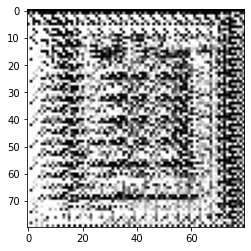

In [243]:
generator = checkpoint.generator

noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)


plt.imshow(generated_image[0, :, :, 0], cmap='gray')

## Create Nice GIF

In [244]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('output/image_at_epoch_{:04d}.png'.format(epoch_no))

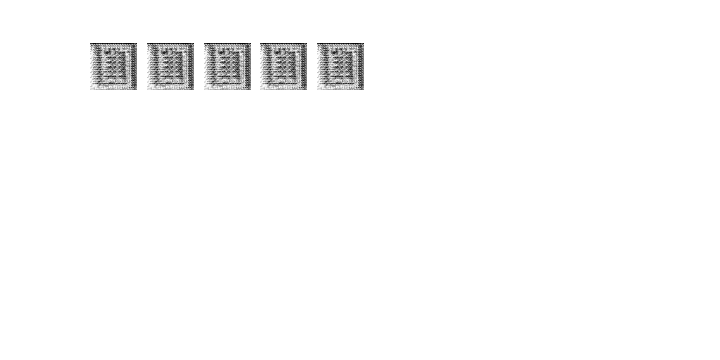

In [245]:
display_image(EPOCHS)

In [246]:
anim_file = 'dcgan_LRG_{}_LRD_{}.gif'.format(lr_gen, lr_dis)

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('output/image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


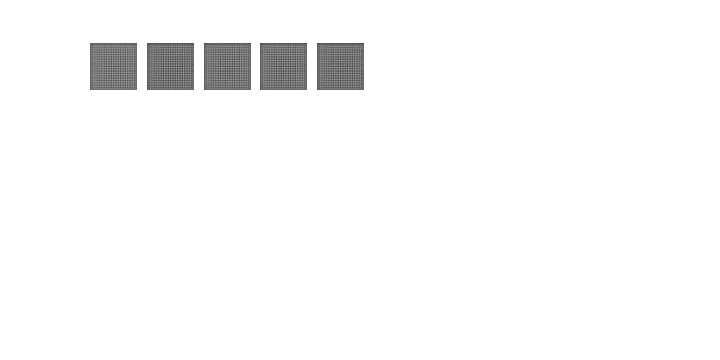

In [247]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

In [248]:
anim_file

'dcgan_LRG_0.0002_LRD_0.0002.gif'